In [13]:
% matplotlib inline

import pandas as pd, numpy as np
import seaborn as sns
import utils.stats as stats
import utils.viz as viz
import statsmodels.formula.api as smf
import utils.viz as viz
from scipy.stats import shapiro
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('poster')

## Structural connectivity distance

In [14]:
data_dir = '/Users/sabine/workspace/distconnect_macaque/data'

df = pd.read_pickle('%s/df_regionwise.pkl' % data_dir)

In [15]:
df = df.rename(columns={'injection distance from nearest primary region': "dist_inj_prim",
                          'incoming': "connectivity_distance"})


# STATS
## Relationship of connectivity distance with distance from primary cortex

In [16]:
model = smf.ols(formula='connectivity_distance ~ location \
                                                 + region_size \
                                                 + dist_inj_prim', data=df[df.connectivity_distance.notnull()]).fit()
print model.summary()

                              OLS Regression Results                             
Dep. Variable:     connectivity_distance   R-squared:                       0.547
Model:                               OLS   Adj. R-squared:                  0.492
Method:                    Least Squares   F-statistic:                     10.05
Date:                   Mon, 08 Oct 2018   Prob (F-statistic):           0.000159
Time:                           15:19:30   Log-Likelihood:                -73.242
No. Observations:                     29   AIC:                             154.5
Df Residuals:                         25   BIC:                             160.0
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       

### Any serious outliers?

In [17]:
df.loc[df.connectivity_distance.notnull(), 'struct_resid'] = model.resid
df.loc[df.connectivity_distance.notnull(), 'struct_stud_resid'] = model.outlier_test()['student_resid']
df.loc[df.connectivity_distance.notnull(), 'struct_unadj_p'] = model.outlier_test()['unadj_p']
df.loc[df.connectivity_distance.notnull(), 'struct_bonf_p'] = model.outlier_test()['bonf(p)']

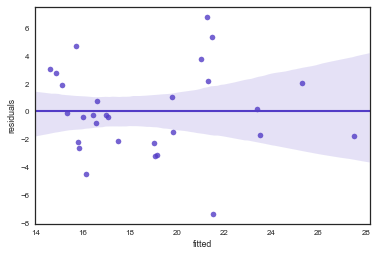

In [27]:
sns.regplot(model.fittedvalues, model.resid, color="#533cc6")
plt.xlabel('fitted')
plt.ylabel('residuals')
plt.savefig('/Users/sabine/Downloads/residuals_against_fitted_struct.png', dpi=300)

In [18]:
cols = ['area', 'dist_inj_prim', 'connectivity_distance', 
        'struct_resid', 'struct_stud_resid', 'struct_unadj_p', 'struct_bonf_p']

In [19]:
df.loc[df.connectivity_distance.notnull(), cols].sort_values(by='struct_stud_resid').head()

,area,dist_inj_prim,connectivity_distance,struct_resid,struct_stud_resid,struct_unadj_p,struct_bonf_p
21,TEpd,27.890625,14.170338,-7.355389,-2.833822,0.009178,0.266148
63,46d,27.796875,11.692618,-4.459523,-1.521566,0.141185,1.000000
10,STPc,10.773438,15.879031,-3.171090,-1.022677,0.316659,1.000000
45,7B,12.906250,16.025179,-3.118912,-1.021401,0.317251,1.000000
62,ProM,8.804688,13.261428,-2.607565,-0.834392,0.412289,1.000000


In [20]:
df.loc[df.connectivity_distance.notnull(), cols].sort_values(by='struct_stud_resid').tail()

,area,dist_inj_prim,connectivity_distance,struct_resid,struct_stud_resid,struct_unadj_p,struct_bonf_p
42,9_46d,19.812500,17.711961,3.077110,1.010308,0.322426,1.00000
7,DP,22.078125,24.766858,3.728277,1.275493,0.214343,1.00000
44,9_46v,26.453125,20.402974,4.673462,1.590997,0.124698,1.00000
47,5,10.250000,26.805691,5.308309,1.773140,0.088898,1.00000
39,7A,19.093750,28.055723,6.781594,2.472970,0.020870,0.60524


## Connectivity distance (corrected)

In [22]:
null = smf.ols(formula='connectivity_distance ~  location \
                                                 + region_size', 
               data=df.loc[df.connectivity_distance.notnull()]).fit()

# for plotting
df.loc[df.connectivity_distance.notnull(), 
       'corrected_condist'] = null.resid + df.loc[df.connectivity_distance.notnull(), 'connectivity_distance'].mean()

In [35]:
df[df.connectivity_distance.notnull()].shape

(29, 30)

In [49]:
null.resid.shape

(29,)

18.755157523504383

In [25]:
sns.set_style('white')
sns.set_context('paper')

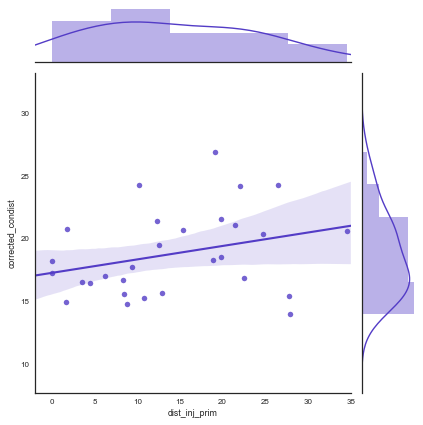

In [26]:
g = sns.jointplot(x="dist_inj_prim", 
                  y="corrected_condist", 
                  data=df[df.connectivity_distance.notnull()], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-2,35), 
                  #ylim=(13,27),
                  stat_func=None,
                  scatter_kws={"s": 30})

#g.savefig('/Users/sabine/Downloads/relationship_struct_noexcl.png', dpi=300)

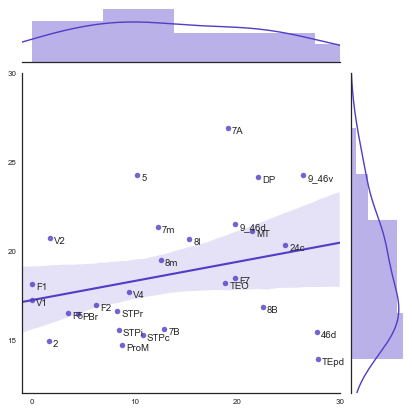

In [69]:
sns.set_style('white')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.4, point['y']-.3, str(point['val']))#, size='xx-small')


g = sns.jointplot(x="dist_inj_prim", 
                  y="corrected_condist", 
                  data=df[df.connectivity_distance.notnull()], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-2,30), 
                  ylim=(13,27),
                  stat_func=None,
                  scatter_kws={"s": 30})

plt.xlim(-1,30)
plt.xticks([0,10,20,30])
plt.xlabel('')

plt.ylim(12,30)
plt.yticks([15, 20, 25, 30])
plt.ylabel('')


label_point(df.dist_inj_prim[df.connectivity_distance.notnull()], 
            df.corrected_condist[df.connectivity_distance.notnull()], 
            df.area[df.connectivity_distance.notnull()], 
            plt.gca()) 


g.savefig('/Users/sabine/Downloads/relationship_struct.png', dpi=300)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


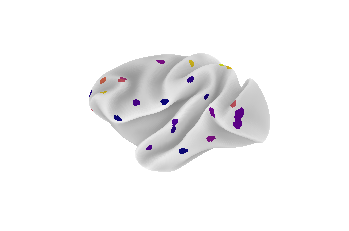

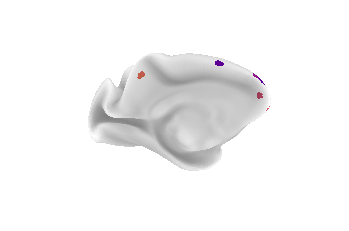

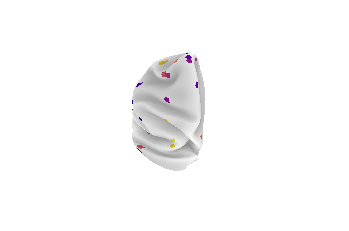

In [65]:
viz.plot_inj_yerkes(df, 
                    'corrected_condist', 
                    vmin=15, vmax=25, 
                    cmap='plasma', 
                    surftype='inflated',
                    views=[(180,0), (0,0), (270,90)],
                    f_save='/Users/sabine/Downloads/surf_struct_condist')

## Connectivity distance (raw)

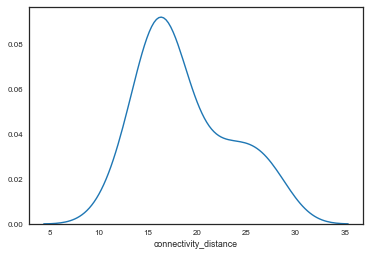

In [66]:
sns.distplot(df.connectivity_distance[df.connectivity_distance.notnull()], hist=False)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


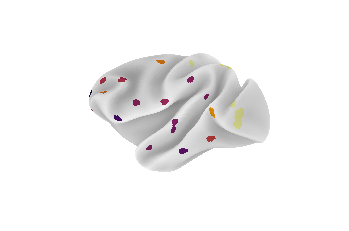

In [67]:
viz.plot_inj_yerkes(df, 'connectivity_distance', vmin=10, vmax=25)

In [68]:
df.to_pickle('./data/df_struct.pkl') # for combining with struct later